# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import scipy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

In [3]:
data = pd.read_csv('preprocessed_data.csv')
print("First Two Rows Of Dataset:")
data.head(2)

First Two Rows Of Dataset:


,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,title,essay
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,154.6,educational support english learners home,students english learners working english seco...
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,299.0,wanted projector hungry learners,students arrive school eager learn polite gene...


In [4]:
print("Shape Of Dataset:\t",data.shape)
print(data.columns)

Shape Of Dataset:	 (109248, 10)
Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'clean_categories', 'clean_subcategories',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'title', 'essay'],
      dtype='object')


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
X = data.drop('project_is_approved',axis = 1)
Y = data['project_is_approved']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,stratify= Y)
print("X_train-length: %f\tY_train-length: %f\nX_test-length: %f\tY_test-length: %f  "%(len(X_train),len(Y_train),len(X_test),len(Y_test)))

X_train-length: 76473.000000	Y_train-length: 76473.000000
X_test-length: 32775.000000	Y_test-length: 32775.000000  


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [6]:
def generate_tfidf(minDf,maxFeatures,feature):
    vectorizer = TfidfVectorizer(min_df=minDf,max_features=maxFeatures)
    vectorizer.fit(X_train[feature])
    X_train_feature_tfidf = vectorizer.transform(X_train[feature])
    X_test_feature_tfidf = vectorizer.transform(X_test[feature])
    return X_train_feature_tfidf,X_test_feature_tfidf,vectorizer.get_feature_names()

### SET 1

In [7]:
#Set 1: 
# 1.1) essay
X_train_essay_tfidf,X_test_essay_tfidf,X_train_essay_tdif_features = generate_tfidf(1,5000,'essay')
print("Shape of X_train_essay : ", X_train_essay_tfidf.shape)
print("Shape of X_test_essay : ", X_test_essay_tfidf.shape)
print(len(X_train_essay_tdif_features))

Shape of X_train_essay :  (76473, 5000)
Shape of X_test_essay :  (32775, 5000)
5000


In [8]:
# 1.2) title
X_train_title_tfidf,X_test_title_tfidf,X_train_title_tdif_features = generate_tfidf(1,5000,'title')
print("Shape of X_train_title : ", X_train_title_tfidf.shape)
print("Shape of X_test_title : ", X_test_title_tfidf.shape)
print(len(X_train_title_tdif_features))

Shape of X_train_title :  (76473, 5000)
Shape of X_test_title :  (32775, 5000)
5000


### SET 2

In [9]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [10]:
def generate_tfidf_w2v(minDf,ngram,maxFeatures,feature):
    vectorizer = TfidfVectorizer(min_df=minDf,max_features=maxFeatures,ngram_range=ngram)
    vectorizer.fit(X_train[feature])
    X_train_feature_tfidf = vectorizer.transform(X_train[feature])
    X_test_feature_tfidf = vectorizer.transform(X_test[feature])
    return X_train_feature_tfidf,X_test_feature_tfidf,vectorizer.get_feature_names()

In [11]:
#Set 2: 
# 2.1) essay

X_train_essay_tfidf_w2v,X_test_essay_tfidf_w2v,X_train_essay_tfidf_w2v_features =  generate_tfidf_w2v(1,(1,1),None,'essay')
print("Shape of X_train_essay : ", X_train_essay_tfidf_w2v.shape)
print("Shape of X_test_essay : ", X_test_essay_tfidf_w2v.shape)
print(len(X_train_essay_tfidf_w2v_features))

Shape of X_train_essay :  (76473, 48765)
Shape of X_test_essay :  (32775, 48765)
48765


In [12]:
# 2.2) title

X_train_title_tfidf_w2v,X_test_title_tfidf_w2v,X_train_title_tfidf_w2v_features =  generate_tfidf_w2v(1,(1,1),None,'title')
print("Shape of X_train_essay : ", X_train_title_tfidf_w2v.shape)
print("Shape of X_test_essay : ", X_test_title_tfidf_w2v.shape)
print(len(X_train_title_tfidf_w2v_features))

Shape of X_train_essay :  (76473, 14198)
Shape of X_test_essay :  (32775, 14198)
14198


In [13]:
def tfidf_w2v_vector_generator(feature_tfidf_w2v,corpus):
    tdif_w2v = []
    #for each essay calculate the tfidf-w2v
    for row in tqdm(feature_tfidf_w2v):
        #convert the row to array
        row_array = row.toarray()
        sentence_avg_w2v = 0
        sum_tdif = 0
        #get all the indexes for which tfidf value is zero
        for index in np.where(row_array != 0)[1]:
            #for each index check if the word exists in glove model
            if(corpus[index] in model):
                #if the word exists in glove model then calculate the numerator
                sentence_avg_w2v += model[corpus[index]] * row_array[0][index]
                #calculate the denominator
                sum_tdif = sum_tdif + row_array[0][index]
        #store the numerator/denominator
        if(sum_tdif == 0):
            sentence_avg_w2v = np.zeros(300)
        else:
            sentence_avg_w2v = sentence_avg_w2v/sum_tdif
        #store the 300 dim. vector for all rows
        tdif_w2v.append(sentence_avg_w2v.tolist())
    return tdif_w2v

In [14]:
X_train_essay_w2v = tfidf_w2v_vector_generator(X_train_essay_tfidf_w2v,X_train_essay_tfidf_w2v_features)
X_test_essay_w2v = tfidf_w2v_vector_generator(X_test_essay_tfidf_w2v,X_train_essay_tfidf_w2v_features)
print("Vector Length X_train_tfidf_w2v:\t",len(X_train_essay_w2v[0]))
print("Number of Vectors  X_train_tfidf_w2v:\t",len(X_train_essay_w2v))
print("Vector Length X_test_tfidf_w2v:\t",len(X_test_essay_w2v[0]))
print("Number of Vectors  X_test_tfidf_w2v:\t",len(X_test_essay_w2v))

76473it [01:12, 1052.24it/s]
32775it [00:32, 1018.24it/s]

Vector Length X_train_tfidf_w2v:	 300
Number of Vectors  X_train_tfidf_w2v:	 76473
Vector Length X_test_tfidf_w2v:	 300
Number of Vectors  X_test_tfidf_w2v:	 32775


In [15]:
X_train_title_w2v = tfidf_w2v_vector_generator(X_train_title_tfidf_w2v,X_train_title_tfidf_w2v_features)
X_test_title_w2v = tfidf_w2v_vector_generator(X_test_title_tfidf_w2v,X_train_title_tfidf_w2v_features)
print("Vector Length X_train_tfidf_w2v:\t",len(X_train_title_w2v[0]))
print("Number of Vectors  X_train_tfidf_w2v:\t",len(X_train_title_w2v))
print("Vector Length X_test_tfidf_w2v:\t",len(X_test_title_w2v[0]))
print("Number of Vectors  X_test_tfidf_w2v:\t",len(X_test_title_w2v))

76473it [00:13, 5848.01it/s]
32775it [00:05, 5949.17it/s]

Vector Length X_train_tfidf_w2v:	 300
Number of Vectors  X_train_tfidf_w2v:	 76473
Vector Length X_test_tfidf_w2v:	 300
Number of Vectors  X_test_tfidf_w2v:	 32775


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [16]:
def generate_dict_feature_class_counts(X_train_combined,feature):
    unique_feature = X_train_combined[feature].unique()
    dict_feature = {}
    for index in range(0,len(unique_feature)):
        number_of_zeros = len(X_train_combined[(X_train_combined[feature] == unique_feature[index]) & (X_train_combined['Y_train']==0)])
        number_of_ones = len(X_train_combined[(X_train_combined[feature] == unique_feature[index]) & (X_train_combined['Y_train']==1)])
        dict_feature[unique_feature[index]]=[number_of_zeros,number_of_ones]
    return dict_feature

In [17]:
X_test_combined = X_test.copy()
X_test_combined['Y_test'] = Y_test
X_train_combined = X_train.copy()
X_train_combined['Y_train'] = Y_train

#### Creating a dict. for categorical_feature, where { categorical_feature:[number_of_zeros,number_of_ones]}

In [18]:

# 1.Creating a dict. for school_state, where {state_name:[number_of_zeros,number_of_ones]}
dict_school_state = generate_dict_feature_class_counts(X_train_combined,'school_state')
print("State_Name Dictionary with respective count for [class 0, class 1]:\n",dict_school_state)
print("*"*123)
# 2.Creating a dict. for teacher_prefix, where {teacher_prefix:[number_of_zeros,number_of_ones]}
dict_teacher_prefix = generate_dict_feature_class_counts(X_train_combined,'teacher_prefix')
print("teacher_prefix Dictionary with respective count for [class 0, class 1]:\n",dict_teacher_prefix)
print("*"*123)
# 3.Creating a dict. for project_grade_category, where {project_grade_category:[number_of_zeros,number_of_ones]}
dict_project_grade_category = generate_dict_feature_class_counts(X_train_combined,'project_grade_category')
print("project_grade_category Dictionary with respective count for [class 0, class 1]:\n",dict_project_grade_category)
print("*"*123)
# 4.Creating a dict. for clean_categories, where {clean_categories:[number_of_zeros,number_of_ones]}
dict_clean_categories = generate_dict_feature_class_counts(X_train_combined,'clean_categories')
print("clean_categories Dictionary with respective count for [class 0, class 1]:\n",dict_clean_categories)
print("*"*123)
# 5.Creating a dict. for clean_subcategories, where {clean_subcategories:[number_of_zeros,number_of_ones]}
dict_clean_subcategories= generate_dict_feature_class_counts(X_train_combined,'clean_subcategories')
print("clean_subcategories Dictionary with respective count for [class 0, class 1]:\n",dict_clean_subcategories)
print("*"*123)

State_Name Dictionary with respective count for [class 0, class 1]:
 {'wa': [210, 1428], 'nh': [33, 183], 'nv': [147, 816], 'ar': [122, 579], 'tx': [971, 4197], 'fl': [727, 3579], 'ca': [1510, 9303], 'in': [284, 1569], 'ga': [438, 2354], 'il': [434, 2604], 'nj': [236, 1358], 'mi': [325, 1856], 'me': [55, 302], 'ks': [70, 373], 'pa': [326, 1851], 'sc': [379, 2411], 'ny': [718, 4421], 'mo': [263, 1569], 'ma': [229, 1460], 'ky': [126, 802], 'al': [184, 1056], 'or': [137, 734], 'nc': [517, 3006], 'tn': [171, 1008], 'ct': [152, 1001], 'va': [227, 1238], 'ia': [61, 390], 'la': [290, 1367], 'az': [234, 1238], 'md': [186, 887], 'wv': [44, 288], 'co': [129, 643], 'nm': [58, 337], 'ms': [142, 766], 'nd': [10, 87], 'ok': [277, 1316], 'ut': [192, 1034], 'mn': [123, 738], 'oh': [217, 1516], 'mt': [36, 139], 'wi': [197, 1065], 'sd': [32, 176], 'ri': [27, 165], 'ak': [41, 212], 'dc': [72, 281], 'de': [26, 222], 'id': [79, 403], 'ne': [36, 180], 'hi': [54, 286], 'wy': [13, 53], 'vt': [12, 47]}
*******

In [19]:
def create_response_coded_features(dict_feature,feature):
    feature_train = []
    for index in X_train.index:
        value_0 = dict_feature[X_train.loc[index,feature]][0]/(dict_feature[X_train.loc[index,feature]][0]+dict_feature[X_train.loc[index,feature]][1])
        value_1 = dict_feature[X_train.loc[index,feature]][1]/(dict_feature[X_train.loc[index,feature]][0]+dict_feature[X_train.loc[index,feature]][1])
        feature_train.append([value_0,value_1])
            
    feature_test = []
    for index in X_test.index:
        if(X_test.loc[index,feature] not in dict_feature):
                feature_test.append([0.5,0.5])
        else:
                value_0 = dict_feature[X_test.loc[index,feature]][0]/(dict_feature[X_test.loc[index,feature]][0]+dict_feature[X_test.loc[index,feature]][1])
                value_1 = dict_feature[X_test.loc[index,feature]][1]/(dict_feature[X_test.loc[index,feature]][0]+dict_feature[X_test.loc[index,feature]][1])
                feature_test.append([value_0,value_1])
    return feature_train,feature_test

### Getting Categorical and numerical features ready

In [20]:
# 1.Replace Value for school_state
school_state_train,school_state_test = create_response_coded_features(dict_school_state,'school_state')

# 2.Replace Value for teacher_prefix
teacher_prefix_train,teacher_prefix_test = create_response_coded_features(dict_teacher_prefix,'teacher_prefix')

# 3.Replace Value for project_grade_category
project_grade_category_train,project_grade_category_test = create_response_coded_features(dict_project_grade_category,'project_grade_category')

# 4.Replace Value for clean_categories
clean_categories_train,clean_categories_test = create_response_coded_features(dict_clean_categories,'clean_categories')

# 5.Replace Value for clean_subcategories
clean_subcategories_train,clean_subcategories_test = create_response_coded_features(dict_clean_subcategories,'clean_subcategories')

price_train = scipy.sparse.csr_matrix(X_train['price'].values.reshape(-1,1))
price_test = scipy.sparse.csr_matrix(X_test['price'].values.reshape(-1,1))

teacher_number_of_previously_posted_projects_train = scipy.sparse.csr_matrix(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
teacher_number_of_previously_posted_projects_test = scipy.sparse.csr_matrix(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

### Generating sentiment Features

In [23]:
#import the classifier
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Define the classifier
sentimentAnalyserClassifier = SentimentIntensityAnalyzer()
def Sentiment_Feature_Generator(X_train):
    list_of_sentiments = []
    for row in tqdm(X_train['essay']):
        ss = list(sentimentAnalyserClassifier.polarity_scores(row).values())
        list_of_sentiments.append(ss)
    return list_of_sentiments

In [24]:
X_train_sentiments = Sentiment_Feature_Generator(X_train)
X_test_sentiments = Sentiment_Feature_Generator(X_test)

100%|███████████████████████████████████████████████████████████████████████████| 32775/32775 [01:01<00:00, 529.86it/s]


### Creating X_train and X_test used while modelling

In [25]:
X_train_set_1_tdif = hstack((school_state_train,teacher_prefix_train,project_grade_category_train,clean_categories_train,clean_subcategories_train,teacher_number_of_previously_posted_projects_train,price_train,X_train_sentiments,X_train_essay_tfidf,X_train_title_tfidf)).tocsr()
X_test_set_1_tdif = hstack((school_state_test,teacher_prefix_test,project_grade_category_test,clean_categories_test,clean_subcategories_test,teacher_number_of_previously_posted_projects_test,price_test,X_test_sentiments,X_test_essay_tfidf,X_test_title_tfidf)).tocsr()

X_train_set_2_tdif = hstack((school_state_train,teacher_prefix_train,project_grade_category_train,clean_categories_train,clean_subcategories_train,teacher_number_of_previously_posted_projects_train,price_train,X_train_sentiments,X_train_title_w2v,X_train_essay_w2v)).tocsr()
X_test_set_2_tdif = hstack((school_state_test,teacher_prefix_test,project_grade_category_test,clean_categories_test,clean_subcategories_test,teacher_number_of_previously_posted_projects_test,price_test,X_test_sentiments,X_test_title_w2v,X_test_essay_w2v)).tocsr()


In [26]:
print(X_train_set_1_tdif.shape)
print(X_test_set_1_tdif.shape)
print(X_train_set_2_tdif.shape)
print(X_test_set_2_tdif.shape)


(76473, 10016)
(32775, 10016)
(76473, 616)
(32775, 616)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [27]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

## 2. Hyperparameter tuning on GBDT Tree

### 2.1 Function that takes in X, Y,params and return the results for all the params on train and CV data.

In [38]:
#decision tree classifier
def find_best_GBDT_classifier(X_train,Y_train,params):
    classifier = xgb.XGBClassifier()
    classifierGridSearch = GridSearchCV(classifier,params,n_jobs=-1,cv =3,scoring = 'roc_auc',return_train_score=True)
    result_RS = classifierGridSearch.fit(X_train,Y_train)
    result = pd.DataFrame.from_dict(result_RS.cv_results_)
    return result,classifierGridSearch.best_params_

### 2.2 Function thats in results returned by above function and returns a matrix so that Heat-Map can be generated

In [39]:
def matrix_formation_for_parameter_heatMap(cv,row,col):
    data_after_cv_train = []
    data_after_cv_test = []
    index = 0
    for row_index in range(0,row):
        col_train = []
        col_test = []
        for col_index in range(0,col):
            col_train.append(cv.loc[index,'mean_train_score'])
            col_test.append(cv.loc[index,'mean_test_score'])
            index +=1
        data_after_cv_train.append(col_train)
        data_after_cv_test.append(col_test)
    return data_after_cv_train,data_after_cv_test

### 2.3 Function that generates heap_map: X_axis = min_smaple_split and Y_axis = max_depth

In [40]:
def generate_heat_map_depth_sampleSplit(data,title):
    sns.heatmap(data = data,annot = True,yticklabels=[0.0001,0.001,0.01,0.1,0.2,0.3],xticklabels=[5,10,50,75,100])
    plt.ylabel('max-depth')
    plt.xlabel('min_samples_split')
    plt.title(title)
    plt.plot()

### SET 1

In [41]:
params = {'n_estimators':[5,10,50,75,100],'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}
cv_results_set_1,best_params_set_1 = find_best_GBDT_classifier(X_train_set_1_tdif,Y_train,params)
print("Best Found Parameters:\t",best_params_set_1)

C:\Users\91985\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Found Parameters:	 {'learning_rate': 0.1, 'n_estimators': 100}


In [42]:
cv_set_1 = cv_results_set_1[['params','mean_train_score','mean_test_score']]

In [43]:
data_after_cv_train_set_1,data_after_cv_test_set_1=matrix_formation_for_parameter_heatMap(cv_set_1,6,5)

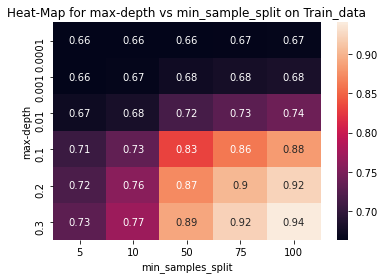

In [44]:
generate_heat_map_depth_sampleSplit(data_after_cv_train_set_1,'Heat-Map for max-depth vs min_sample_split on Train_data')


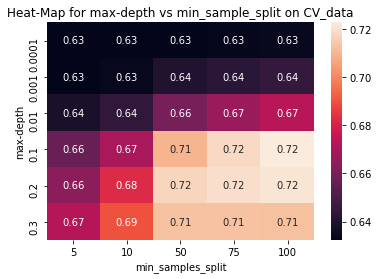

In [45]:
generate_heat_map_depth_sampleSplit(data_after_cv_test_set_1,'Heat-Map for max-depth vs min_sample_split on CV_data')

### SEt 2

In [66]:
params = {'n_estimators':[5,10,50,75,100],'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}
cv_results_set_2,best_params_set_2 = find_best_GBDT_classifier(X_train_set_2_tdif,Y_train,params)
print("Best Found Parameters:\t",best_params_set_2)

C:\Users\91985\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Found Parameters:	 {'learning_rate': 0.1, 'n_estimators': 100}


In [67]:
cv_set_2 = cv_results_set_2[['params','mean_train_score','mean_test_score']]

In [68]:
data_after_cv_train_set_2,data_after_cv_test_set_2=matrix_formation_for_parameter_heatMap(cv_set_2,6,5)

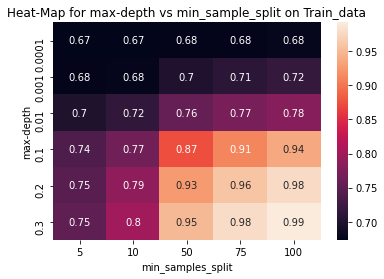

In [69]:
generate_heat_map_depth_sampleSplit(data_after_cv_train_set_2,'Heat-Map for max-depth vs min_sample_split on Train_data')

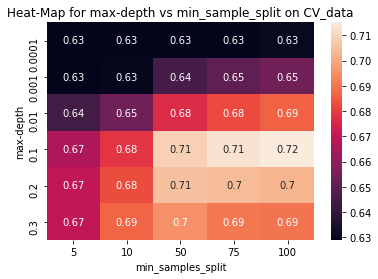

In [70]:
generate_heat_map_depth_sampleSplit(data_after_cv_test_set_2,'Heat-Map for max-depth vs min_sample_split on CV_data')

## 3. Applying decision tree algo. with the best found parameters from above

### 3.1 Decision Tree function that generates AUC-ROC plot and return the predicted values and well as feature importance

In [56]:
#this function return The predicted Y_test values
def GBDT(X_train,Y_train,X_test,Y_test,learningRate,estimators):
    classifier = xgb.XGBClassifier(learning_rate=learningRate,n_estimators= estimators)
    classifier.fit(X_train,Y_train)
    
    Y_Train_Pred = classifier.predict_proba(X_train)[:,1]
    Y_Test_Pred = classifier.predict_proba(X_test)[:,1]

    Train_FPR, Train_TPR, Tr_Thresholds = roc_curve(Y_train, Y_Train_Pred)
    Test_FPR, Test_TPR, Te_Thresholds = roc_curve(Y_test, Y_Test_Pred)
    #code used from sample sol. of naive bayes
    plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
    plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-AUC PLOTS Train-Test Data")
    plt.grid()
    plt.show()
    return classifier.predict(X_test),classifier.feature_importances_

### 3.2 Function that takes in confusion matrix and return a Heat-Map

In [57]:
def HeatMapForConfusionMatrix(Test_CM):
    plt.title('Testing Confusion Matrix')
    sns.heatmap(Test_CM, annot=True,fmt="d",cmap='Blues',xticklabels = ['No','Yes'],yticklabels=['No','Yes'])
    plt.ylabel('actual labels');
    plt.xlabel('predicted labels');
    plt.show();

C:\Users\91985\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


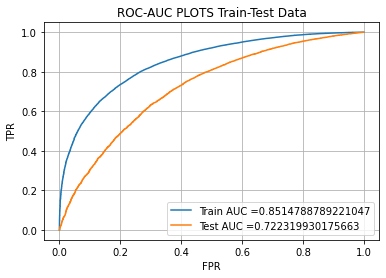

In [58]:
Y_Test_hat_Set_1,feature_importance_set_1 = GBDT(X_train_set_1_tdif,Y_train,X_test_set_1_tdif,Y_test,best_params_set_1['learning_rate'],best_params_set_1['n_estimators'])

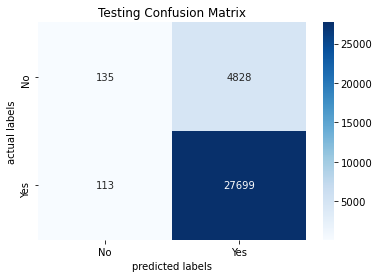

In [59]:
Test_CM_Set_1 = confusion_matrix(Y_test, Y_Test_hat_Set_1)
HeatMapForConfusionMatrix(Test_CM_Set_1)

C:\Users\91985\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


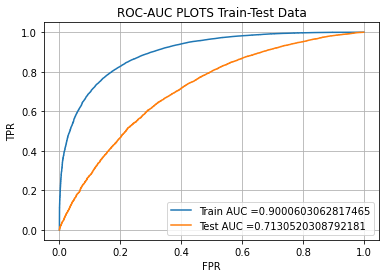

In [64]:
Y_Test_hat_Set_2,feature_importance_set_2 = GBDT(X_train_set_2_tdif,Y_train,X_test_set_2_tdif,Y_test,0.1,100)

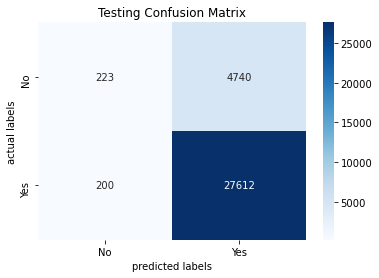

In [65]:
Test_CM_Set_2 = confusion_matrix(Y_test, Y_Test_hat_Set_2)
HeatMapForConfusionMatrix(Test_CM_Set_2)

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [62]:
summary = pd.DataFrame({'Vectorizer':['Tfidf','Tfidf-w2v'],'Model':['XGBoost','XGBoost'],'n_estimators':[100,100],'learning_rate':[0.1,0.01],'auc':[0.72,0.68]})
summary

,Vectorizer,Model,n_estimators,learning_rate,auc
0,Tfidf,XGBoost,100,0.10,0.72
1,Tfidf-w2v,XGBoost,100,0.01,0.68
